In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

In [41]:
test = pd.read_csv("D:/전력예측/test.csv", encoding='euc-kr')
train = pd.read_csv("D:/전력예측/train.csv", encoding='euc-kr')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


### 1. 요일변수, 주말변수 생성

In [42]:
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

In [43]:
def coding(df):
    df.rename(columns={'num':'건물번호',
                       '전력사용량(kWh)':'전력사용량',
                       '기온(°C)':'기온',
                       '풍속(m/s)':'풍속',
                       '습도(%)':'습도',
                       '강수량(mm, 6시간)':'강수량',
                       '일조(hr, 3시간)':'일조',
                       '강수량(mm)':'강수량',
                       '일조(hr)':'일조'}, inplace=True)
    
    df['date_time'] = pd.to_datetime(df['date_time'])

    # 연도, 월, 일, 시간 column 생성
    df['연도'] = df['date_time'].dt.year
    df['월'] = df['date_time'].dt.month
    df['일'] = df['date_time'].dt.day
    df['시간'] = df['date_time'].dt.hour
    
    df['요일'] = df['date_time'].apply(weekday)
    df['주말'] = df['date_time'].apply(weekend)
    
    df = df.astype({'건물번호':'int'})
    
    df['체감온도'] = 13.12 + 0.6215*df['기온'] - 11.37*df['풍속']**0.16 + 0.3965*df['풍속']**0.16*df['기온']
    df['불쾌지수'] = 1.8*df['기온'] - 0.55*(1-df['습도'])*(1.8*df['기온']-26) + 32
    
    return(df)

In [44]:
train = coding(df=train)
test = coding(df=test)

### 2. test셋 결측치 히트맵으로 확인

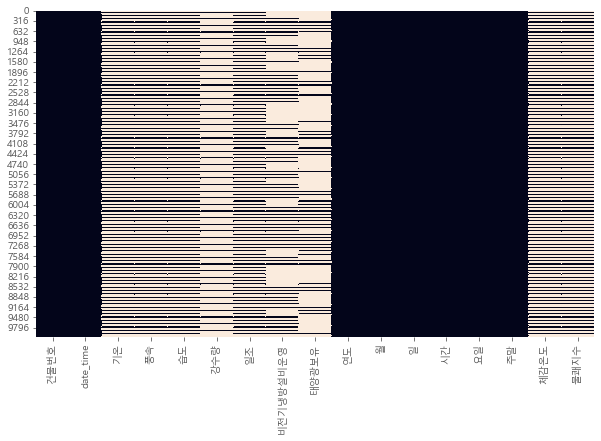

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(),cbar=False)
plt.show();

#### (1) 기온, 풍속, 습도, 강수량, 일조, 체감온도, 불쾌지수와 같은 연속형변수의 경우, 결측치에 패턴을 보이고 있다
#### 실제로 강수량은 4행, 나머지 연속형 변수는 2행 단위로 결측치가 존재했음 -> 이전값으로 보간

#### (2) 비전기냉방시설비운영, 태양광보유 범주형 변수는 결측치가 제각각 존재함
#### 하지만, 미래에 보유했으나 과거에 보유한 근황이 없는 것으로 보아 단순 결측치로 보임. 
#### 따라서 train 데이터셋의 건물번호별 보유 유무를 가지고 보간


In [45]:
# pad로 지정하여 앞 행의 값으로 보간하도록 설정
 
test['기온'] = test['기온'].interpolate(method='pad')
test['풍속'] = test['풍속'].interpolate(method='pad')
test['습도'] = test['습도'].interpolate(method='pad')
test['일조'] = test['일조'].interpolate(method='pad')
test['강수량'] = test['강수량'].interpolate(method='pad')
test['체감온도'] = test['체감온도'].interpolate(method='pad')
test['불쾌지수'] = test['불쾌지수'].interpolate(method='pad')

In [46]:
# 범주형 변수 결측치 보간

train[['건물번호', '비전기냉방설비운영','태양광보유']]

ice={}
hot={}
count=0

for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']

for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['건물번호'][i]]
    test.loc[i, '태양광보유']=hot[test['건물번호'][i]]

In [9]:
test.isnull().sum()

건물번호         0
date_time    0
기온           0
풍속           0
습도           0
강수량          0
일조           0
비전기냉방설비운영    0
태양광보유        0
연도           0
월            0
일            0
시간           0
요일           0
주말           0
체감온도         0
불쾌지수         0
dtype: int64

### 3. 건물번호 군집화
#### - 건물번호가 1~60개가 있는데, 건물별로 특성이 유사한 집단끼리 묶기 위한 작업

In [13]:
train['건물번호'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60.])

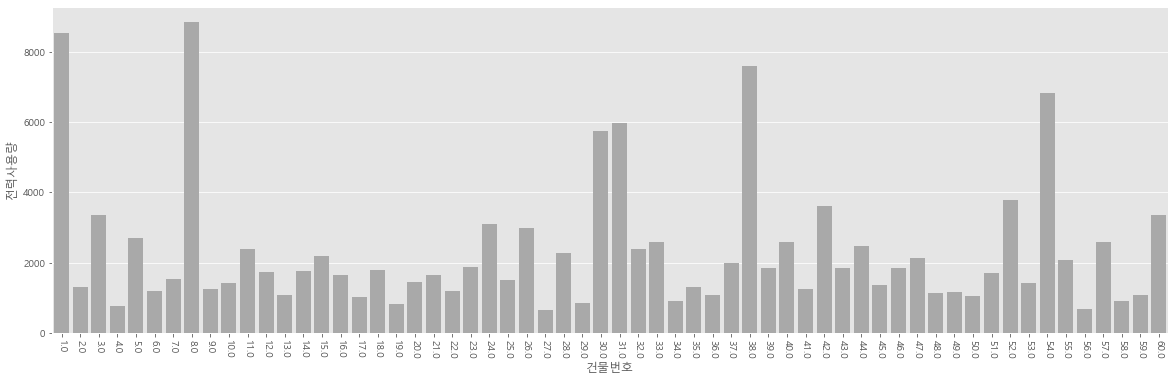

In [14]:
plt.figure(figsize=(20,6))
sns.barplot(x='건물번호',y='전력사용량',data=train,ci=None,color='darkgrey')
plt.xticks(rotation=-90)
plt.show();

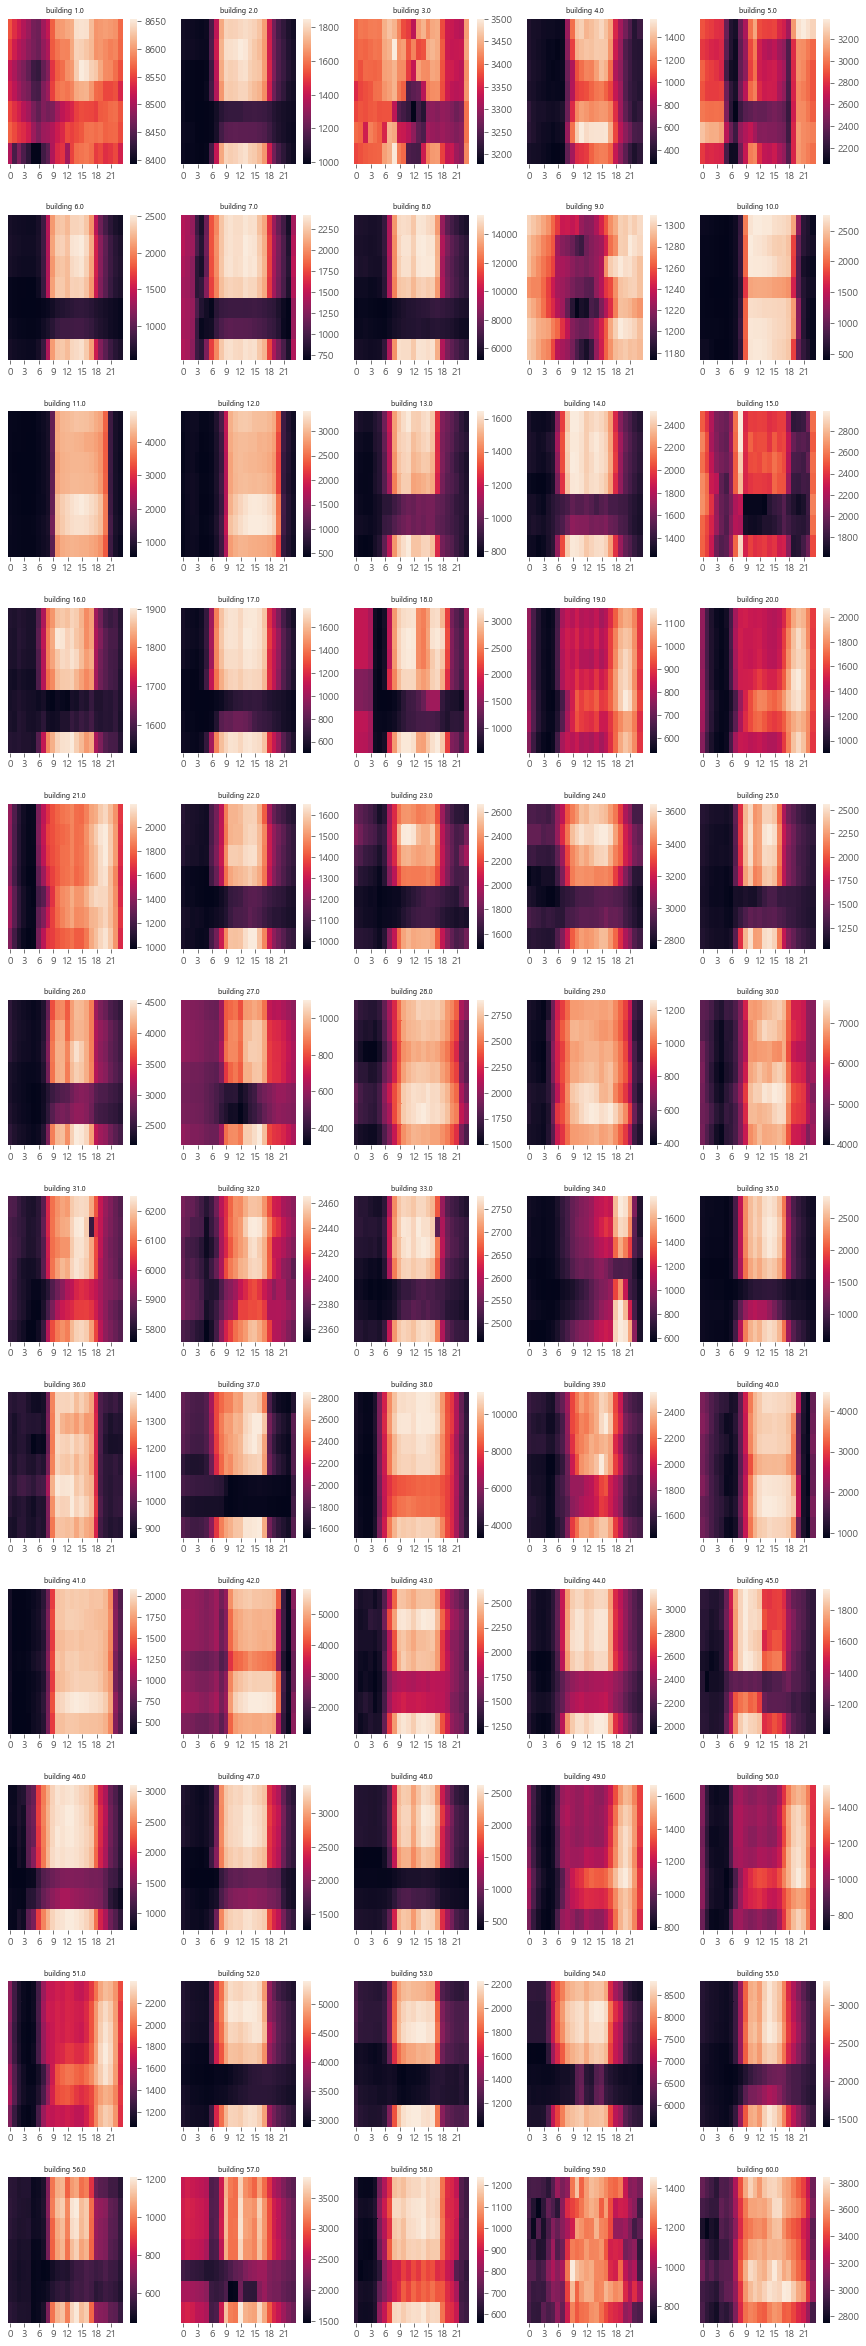

In [21]:
fig = plt.figure(figsize = (15, 40))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for num in train['건물번호'].unique():
    df = train[train.건물번호 == num]
    df = df.groupby(['요일', '시간'])['전력사용량'].mean().reset_index().pivot('요일', '시간', '전력사용량')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}', fontsize=7)
    plt.xlabel('')
    plt.ylabel()
    plt.yticks([])

In [51]:
df.iloc[:,1:3]

시간,1,2
요일,,
금,8539.398000,8524.980000
목,8525.790000,8509.536000
수,8503.380000,8485.884000
월,8513.723077,8496.625846
일,8540.046000,8528.598000
토,8555.760000,8542.854000
화,8442.414000,8475.948000


#### 건물별로 요일, 시간대별로 사용량이 상이한 것을 알 수 있다
#### 따라서 시간대, 요일, 전력사용량 column을 기준으로 각 건물번호를 군집화하여 건물번호 column을 축소하자

#### 핵심은 각 건물번호별로 똑같은 클러스터를 가져야함
- 요일, 시간, 전력사용량 간의 상과관계를 보자
- 상관관계를 보고, 전력사용량과 높은 상관을 가진 변수를 이용해 클러스터링을 진행하자

In [47]:
build = train.groupby(['건물번호','요일', '시간'])['전력사용량'].mean().reset_index()

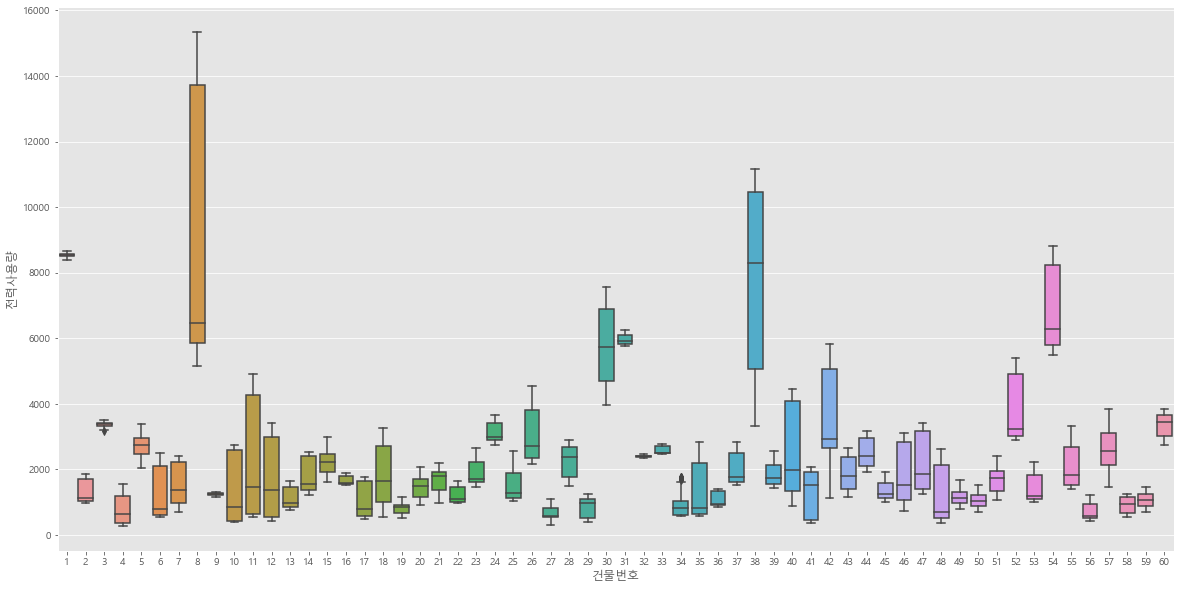

In [48]:
plt.figure(figsize=(20,10))
sns.boxplot(x='건물번호',y='전력사용량',data=build,orient='v')
plt.show();

In [138]:
build_stat = build.groupby('건물번호')['전력사용량'].agg([('전력사용량 최댓값', 'max'), 
('전력사용량 최솟값', 'min'), ('전력사용량 평균','mean'),('전력사용량 중앙값','median'),
('전력사용량 표준편차','std')])

build_stat.head()

,전력사용량 최댓값,전력사용량 최솟값,전력사용량 평균,전력사용량 중앙값,전력사용량 표준편차
건물번호,,,,,
1,8653.770000,8392.842,8543.294059,8553.294692,55.643066
2,1851.606000,986.580,1299.033532,1133.228423,325.037786
3,3500.227218,3178.332,3371.356204,3386.697462,64.625138
4,1563.732000,271.404,764.939419,625.568796,431.248271
5,3384.468000,2052.396,2714.437764,2756.414769,301.851941


#### 최적 군집수를 판단하기 위해 엘보우 기법 이용

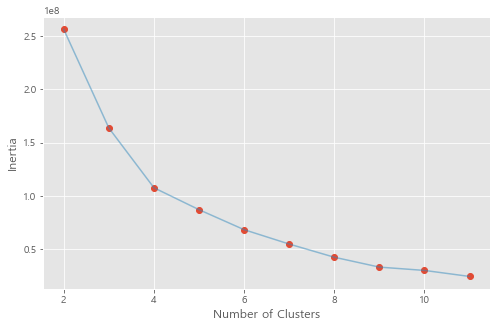

In [139]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], build_stat)

#### 실루엣 계수 평가

In [76]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

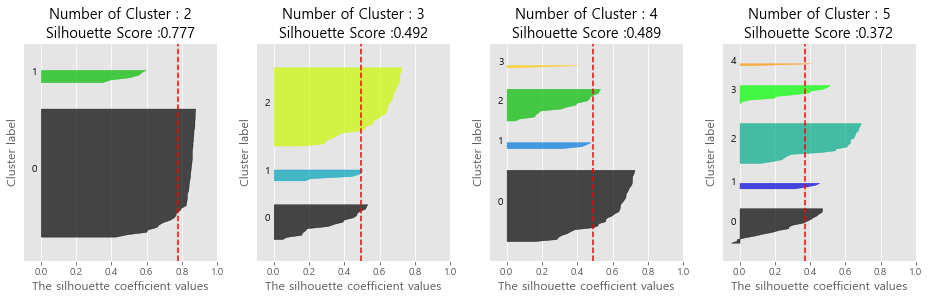

In [140]:
visualize_silhouette([ 2, 3, 4, 5], build_stat)

In [141]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(build_stat)
KMeans(n_clusters=3, random_state=0)

KMeans(n_clusters=3, random_state=0)

#### PCA를 이용해 차원축소 후, 클러스터링이 잘됐는지 시각화

In [142]:
from sklearn.decomposition import PCA
    
build_stat['클러스터'] = kmeans.labels_
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(build_stat)

build_stat['pca_x'] = pca_transformed[:,0]
build_stat['pca_y'] = pca_transformed[:,1]

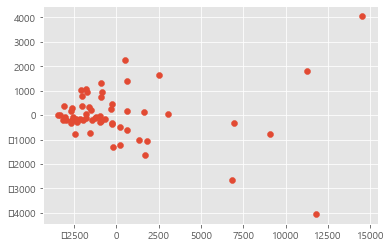

In [143]:
plt.scatter(x=build_stat['pca_x'], y=build_stat['pca_y'])
plt.show();

#### 군집 3개일 때

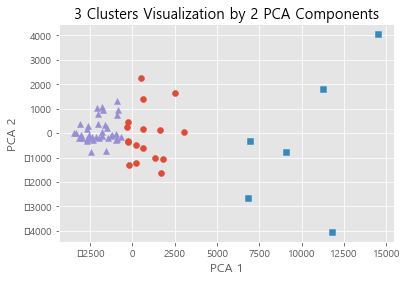

In [144]:
# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = build_stat[build_stat['클러스터']==0].index
marker1_ind = build_stat[build_stat['클러스터']==1].index
marker2_ind = build_stat[build_stat['클러스터']==2].index

# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 마커 표시
plt.scatter(x=build_stat.loc[marker0_ind, 'pca_x'], y=build_stat.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=build_stat.loc[marker1_ind, 'pca_x'], y=build_stat.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=build_stat.loc[marker2_ind, 'pca_x'], y=build_stat.loc[marker2_ind, 'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

#### 군집 4개일 때

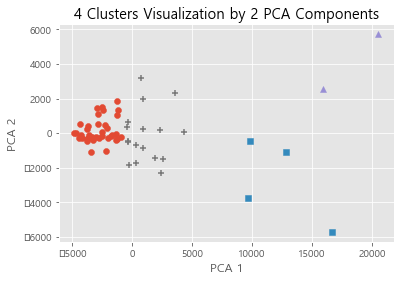

In [145]:
# cluster
kmeans2 = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0)
kmeans2.fit(build_stat)
KMeans(n_clusters=4, random_state=0)

# pca
build_stat['클러스터'] = kmeans2.labels_
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(build_stat)

build_stat['pca_x'] = pca_transformed[:,0]
build_stat['pca_y'] = pca_transformed[:,1]

# 시각화 
marker0_ind = build_stat[build_stat['클러스터']==0].index
marker1_ind = build_stat[build_stat['클러스터']==1].index
marker2_ind = build_stat[build_stat['클러스터']==2].index
marker3_ind = build_stat[build_stat['클러스터']==3].index

plt.scatter(x=build_stat.loc[marker0_ind, 'pca_x'], y=build_stat.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=build_stat.loc[marker1_ind, 'pca_x'], y=build_stat.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=build_stat.loc[marker2_ind, 'pca_x'], y=build_stat.loc[marker2_ind, 'pca_y'], marker='^')
plt.scatter(x=build_stat.loc[marker3_ind, 'pca_x'], y=build_stat.loc[marker3_ind, 'pca_y'], marker='+')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('4 Clusters Visualization by 2 PCA Components')
plt.show()

In [146]:
def merge_df(build_stat, train):
    
    build_stat = build_stat.reset_index(drop=False)
    build_stat = build_stat[['건물번호', '클러스터']]
    merged_df = pd.merge(build_stat, train, on='건물번호')
    
    return merged_df

train = merge_df(build_stat,train)
train.head()

,건물번호,클러스터_x,클러스터_y,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,연도,월,일,시간,요일,주말,체감온도,불쾌지수
0,1,1,2,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020,6,1,0,월,0,18.973374,347.964
1,1,1,2,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020,6,1,1,월,0,18.960338,353.930
2,1,1,2,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,2,월,0,18.658598,335.750
3,1,1,2,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020,6,1,3,월,0,18.218957,299.390
4,1,1,2,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020,6,1,4,월,0,18.081523,292.830


In [148]:
train['클러스터_x'].unique()

array([1, 0, 3, 2])

In [149]:
# 0,1,2,3으로 반환했을 떄 시각화가 안되서...

train['클러스터_x'] = train['클러스터_x'].replace({0: 1, 1: 2, 2: 3, 3: 4})

In [135]:
train.groupby(['요일', '시간'])['전력사용량'].mean().reset_index().pivot('요일', '시간', '전력사용량')

시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
요일,,,,,,,,,,,,,,,,,,,,,
금,1876.664863,1827.578100,1794.857519,1763.030700,1752.246531,1815.992636,1956.628450,2224.661252,2546.889298,2847.026402,...,3110.705235,3097.826838,3077.697364,2944.119012,2639.730413,2482.658502,2305.776911,2073.189653,1923.440512,1909.849797
목,1872.927054,1824.051682,1787.521370,1758.707178,1754.662641,1810.752213,1956.656690,2240.561236,2565.767478,2855.959595,...,3130.815991,3126.499605,3114.629940,2980.563428,2684.648901,2522.242544,2325.946313,2119.543190,1958.639655,1937.470938
수,1862.869499,1808.095973,1778.411812,1742.665487,1739.855690,1798.761191,1937.099359,2208.105913,2536.908760,2823.153791,...,3117.019622,3107.898325,3094.000293,2968.453472,2655.781220,2489.161363,2296.792426,2089.889448,1948.884432,1931.204610
월,1808.563085,1763.500717,1728.043039,1697.272011,1701.072620,1768.581084,1909.516791,2181.784120,2497.490083,2783.744264,...,3055.062358,3051.444129,3035.607545,2919.673144,2625.005482,2463.461877,2282.345713,2078.866155,1934.746536,1916.396501
일,1818.992047,1767.580279,1733.766239,1701.041291,1682.763823,1703.958844,1763.636076,1839.096703,1940.150390,2082.651932,...,2403.270568,2422.501083,2420.215581,2410.452121,2360.934672,2315.293507,2202.676274,1998.536371,1883.762039,1875.399708
토,1847.708469,1801.981150,1769.734936,1737.079684,1714.618738,1741.356476,1796.628124,1882.582240,2006.531589,2170.494718,...,2433.575199,2433.305163,2431.377588,2418.047658,2371.429771,2327.415571,2209.103657,1997.744642,1879.614297,1881.165112
화,1840.719217,1790.612654,1758.275093,1723.529312,1720.482572,1782.461217,1925.494260,2199.071083,2531.325206,2826.602054,...,3091.581463,3089.391299,3074.740764,2951.323187,2659.894707,2485.808972,2300.049967,2099.703979,1943.592586,1927.830762


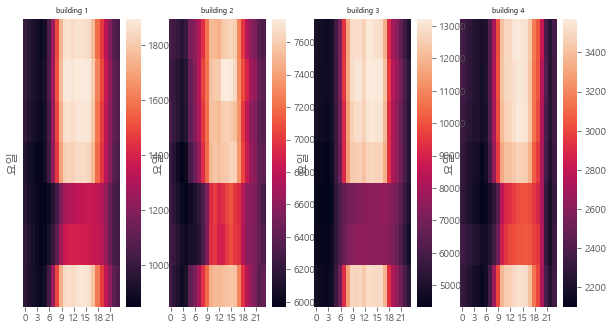

In [156]:
fig = plt.figure(figsize = (10,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

for num in train['클러스터_x'].unique():
    df = train[train.클러스터_x == num]
    df = df.groupby(['요일', '시간'])['전력사용량'].mean().reset_index().pivot('요일', '시간', '전력사용량')
    plt.subplot(1, 4, num)
    sns.heatmap(df)
    plt.title(f'building {num}', fontsize=7)
    plt.xlabel('')
    plt.yticks([])

* 각 건물번호의 통계량을 이용해 클러스터링을 했을 때, 시간과 요일을 고려하지 않아서 원본 데이터프레임 내에선 제대로 분류가 안됨